        STEP 0. IMPORTING ALL NEEDED LIBRARIES
Before creating, compiling and training the DQNAgent it is first import to import all needed Libraries:
- SimulatorEnv: The Python Class that represents the ASPEN+ Simulation
    - Simulator: The ASPEN+ Simulator Class
- keras: The Reinforcement Learning Function Library
    - models:
        - Sequential: Learning Model (Sequence2Sequence)
    - layers:
        - Dense: The most common DNN Layer Type
        - Flatten: Layer used for Flattening the Dimensions of the Input
    - optimizers:
        - Adam: Stoichastic Gradient Descent optimization method
- rl: Further extention of the Keras-RL Library
    - agent.dqn: Importing a Deep-Q-Network agent
        - DQNAgent: A predifined DQN Agent, made by keras-rl
    - policy:
        - EpsGreedyQPolicy: Epsilon-Greedy is a policy that balances Exploration&Exploitation
        - LinearAnnealedPolicy: Calculates the threshold value following a deceasing linear function
    - memory:
        - SequenctialMemory: Since the Leanring model is Sequential, the same is chosen for the Memory.
    - callbacks:
        - ModelIntervalCheckpoint: used to make intermediate saves of the model weights.
        - FileLogger: sumplementary function to the one above, used for saving indexes. 
- numpy: Calculus extension for Python
- matplotlib: Plotting Library for Python 

In [2]:
# Importing the ASPEN+ Simulation:
from SimulationEnv import Simulator
# Importing the Keras Libraries
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
# Importing the Keras Extention Libraries
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory
from rl.callbacks import ModelIntervalCheckpoint, FileLogger
# Importing the Auxiliary Libraries
import os
import numpy as np
import matplotlib.pyplot as plt

        STEP 1. DEFINING TRAINING CONSTANTS
- STEPS: Is the Total number of choices the Agent makes during traing, in this case 30_000 were chosen, due to the relative simplicity of the problem.

- INTERVAL: Is the number of choices during a single Epoch/Interval, by "cutting" the overall training in smaller segments the change of Errors is lowered.

- WARMUP_STEPS: Is the amount of exploratory steps the Agent can take before starting with the Training.

- MEMORY_LIMIT: Is the amount of memory the agent has of its past actions. Too much and too many "mistakes" are considered, too little and the agent "Hyperfocuses"

- DISCOUNT: Signifies how much the Agent cares for future actions. In our case since out moder is sequential future actions are very much important to the training.

- LEARNING_RATE: Signifies the rate-of change to the model weights, based on the environemental input.

In [3]:
STEPS = 20_000
WARMUP_STEPS = 100
MEMORY_LIMIT = 10_000
DISCOUNT = 0.95
LEARNING_RATE = 0.001

        STEP 2. INITIALIZING THE ENVIRONMENT 
The next step is relatively straight forward, the ASPEN+ Simulation is Initialized in the background.

The reason for starting it in the background  is due to the fact that Visualization makes the process a lot slower.

Moreover, we define the number of actions possibles for the Agent, since it is going to be used for the creation of the model.

In [4]:
# Initializing the Environement
env = Simulator()
nb_actions = env.action_space.n # Number of Possible Action (CSTR or PFR)

        STEP 3. CONSTRUCT THE DEEP-NEURAL-NETWORK (DNN)
- As it can be seen the model is chosen be Sequential, since in this case the agent needs to learn, how to take 

sequentially optimal options through the presented training.

- Second is a Flatten layer, used for the input of the DNN, in this case we need to Flatten the Environements input

which is based on the predefined observation_space, defined in the SimulationEnv.

- Next 3 Equally sized Dense layers are implemented each with 128 Nodes. The more the nodes, the longer it needs to training

but also it is more capable of more "Complex Thoughts". The activation layer is chosen to be "RELU" or Rectified Linear,

which sets a threshold, and depending on the value of the input, outputs either 0 or 1.

- Finally another Dense layer is created, however in this case the node is singlar, and can also be defined as the  output of the DNN

since, depending on the weights of the previous 3 dense layers, the agent ends up chosing between 2 options CSTR or PFR



In [5]:
model = Sequential() # Sequential model
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(64,activation="relu"))  #16x3 Relu Dense Layer
model.add(Dense(64,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(nb_actions,activation="linear")) #activation is black and white 

        STEP 4.DEFINING THE FUNCTIONS NEEDED FOR THE DQNAGENT AND COMPILING IT.
- POLICY: The policy can be defined as the strategy employed by the agent to reach the goal defined.

In this case an Epsilon-Greedy policy is taken, which is a means of balancing betweeen exploration and exploitation. 

The attribute of this policy is "epsilon" which is the exploration factor, and is set between 1 and 0.05.

- MEMORY: The memory as previously explained, is the amount of "choice-outcome" memory that is given to the agent.

The amount of memory-limit that is given to the Agent needs to be chosen as such that it is not too large, 

since that has the result of making it consider a lot of early "bad decision". However if it is made too small 

the agent might hyperfocus in an inoptimal solution and make no progress.

- OPTIMIZER: This defines how the agent optimizes its decision making, 

in this case a Stoichastic Gradient Descent optimization method is used

- DQNAGENT: Is the function that calls a predefined DQNA agent, onto which some parameters need to passed:
        - Model: is the predefined model/DNN which the agent will use during training
        - nb_steps: is the maximum amount of steps that the agent can take during training 
        - nb_steps_warmup

In [6]:
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr="eps", value_max=1, value_min=.05, value_test=0, nb_steps=STEPS)
memory = SequentialMemory(limit=MEMORY_LIMIT, window_length=1)
optimizer = Adam(lr=LEARNING_RATE)

dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=WARMUP_STEPS, target_model_update=1e-2,policy=policy, gamma=DISCOUNT)
dqn.compile(optimizer=optimizer, metrics=["mae"])

In [7]:
w_file = "C:/Users/s2199718/Desktop/DiscreteCase/ModelBackup/dqn-{step:02d}_weights.h5f"
check_w_file = "C:/Users/s2199718/Desktop/DiscreteCase/ModelBackup/train_w-{step:02d}_weights.h5f"


log_file = "C:/Users/s2199718/Desktop/DiscreteCase/ModelBackup/training_w_-{step:02d}_log.json"
callbacks = [ModelIntervalCheckpoint(check_w_file, interval=1000)]
callbacks += [FileLogger(log_file, interval=250)]


hist = dqn.fit(env, callbacks=callbacks, nb_steps=STEPS,log_interval=1e4)
reward_data = np.array(hist.history["episode_reward"])
print(hist.history.keys())


Training for 20000 steps ...
Interval 1.0 (0 steps performed)


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


10000/10000 [==============================] - 16008s 2s/step - reward: 0.2211
2500 episodes - episode_reward: 0.884 [0.652, 0.953] - loss: 0.010 - mae: 0.340 - mean_q: 0.637 - mean_eps: 0.760

Interval 2.0 (10000 steps performed)
10000/10000 [==============================] - 18040s 2s/step - reward: 0.2329
done, took 34046.097 seconds
dict_keys(['episode_reward', 'nb_episode_steps', 'nb_steps'])


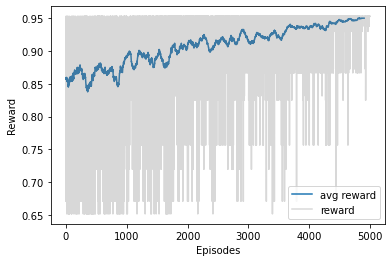

In [8]:
def running_mean(x, episode_number):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[episode_number:] - cumsum[:-episode_number]) / episode_number
smoothed_rews = running_mean(reward_data, 100)

plt.plot(np.arange(np.shape(smoothed_rews)[0])[-len(smoothed_rews):], smoothed_rews)
plt.plot(np.arange(np.shape(reward_data)[0]), reward_data, color='grey', alpha=0.3)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend(["avg reward", "reward"], loc=4)
plt.savefig('Learning2.png', dpi=300,bbox_inches="tight" )

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(reward_data).T
df.to_excel(excel_writer = 'C:/Users/s2199718/Desktop/DiscreteCase/Excel/data.xlsx')